# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import MessagePassing, BatchNorm
from torch_geometric.utils import to_networkx, subgraph, k_hop_subgraph
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Cora Dataset

In [3]:
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]

In [4]:
#Jumlah Node
data.num_nodes

2708

In [5]:
#jumlah edge
data.num_edges

10556

In [6]:
#dimensi fitur
data.num_features

1433

In [7]:
#jumlah keasl
dataset.num_classes

7

In [8]:
#nama kelas
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [9]:
#nodes belong to classes
data.y.bincount()

tensor([351, 217, 418, 818, 426, 298, 180])

In [11]:
class_counts = data.y.bincount()
for class_idx in range(len(class_counts)):
    print(f"Kelas {class_idx}: {class_counts[class_idx].item()} nodes")

Kelas 0: 351 nodes
Kelas 1: 217 nodes
Kelas 2: 418 nodes
Kelas 3: 818 nodes
Kelas 4: 426 nodes
Kelas 5: 298 nodes
Kelas 6: 180 nodes


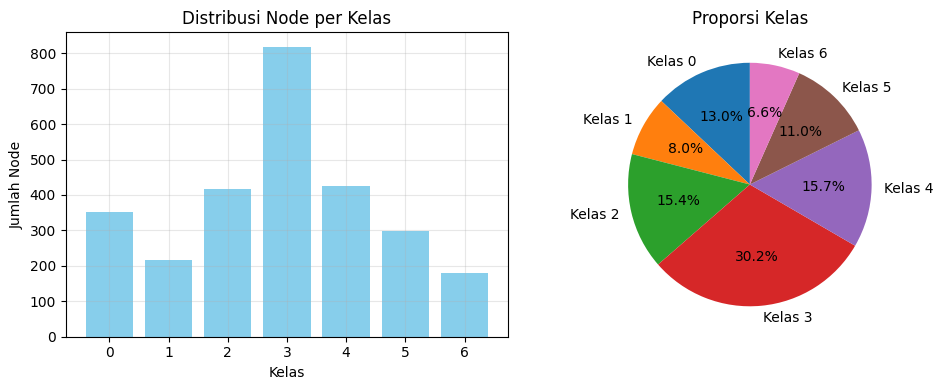

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(len(class_counts)), class_counts.numpy(), color='skyblue')
plt.title('Distribusi Node per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Node')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(class_counts.numpy(), labels=[f'Kelas {i}' for i in range(len(class_counts))], 
        autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Kelas')

plt.tight_layout()
plt.show()

In [14]:
#train nodes
data.train_mask.sum().item()

140

In [15]:
print(f"\nTrain ratio: {data.train_mask.sum().item()/data.num_nodes:.2%}")


Train ratio: 5.17%


In [16]:
#validation nodes
data.val_mask.sum().item()

500

In [17]:
print(f"Validation ratio: {data.val_mask.sum().item()/data.num_nodes:.2%}")

Validation ratio: 18.46%


In [18]:
#test nodes
data.test_mask.sum().item()

1000

In [19]:
print(f"Test ratio: {data.test_mask.sum().item()/data.num_nodes:.2%}")

Test ratio: 36.93%


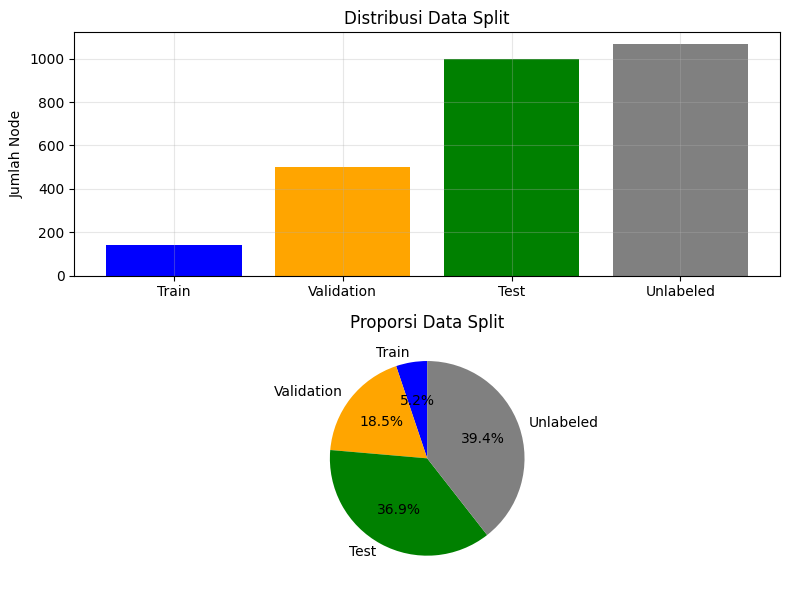

In [20]:
split_counts = {
    'Train': data.train_mask.sum().item(),
    'Validation': data.val_mask.sum().item(),
    'Test': data.test_mask.sum().item(),
    'Unlabeled': data.num_nodes - (data.train_mask.sum().item() + 
                                  data.val_mask.sum().item() + 
                                  data.test_mask.sum().item())
}

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.bar(split_counts.keys(), split_counts.values(), color=['blue', 'orange', 'green', 'gray'])
plt.title('Distribusi Data Split')
plt.ylabel('Jumlah Node')
plt.grid(alpha=0.3)

plt.subplot(2, 1, 2)
colors = ['blue', 'orange', 'green', 'gray']
plt.pie(split_counts.values(), labels=split_counts.keys(), colors=colors,
        autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Data Split')

plt.tight_layout()
plt.show()

In [21]:
#edge density
f"{data.num_edges / (data.num_nodes * (data.num_nodes - 1)):.4f}"

'0.0014'

In [24]:
edge_density = data.num_edges / (data.num_nodes * (data.num_nodes - 1))
avg_degree = 2 * data.num_edges / data.num_nodes

print(f"Edge Density: {edge_density:.4f}")
print(f"Average Degree: {avg_degree:.2f}")
print(f"\nInterpretasi:")
print(f"• Density {edge_density:.4f} = grafik sangat sparse")
print(f"• Avg degree {avg_degree:.2f} = rata-rata setiap node terhubung ke {avg_degree:.1f} node lain")

Edge Density: 0.0014
Average Degree: 7.80

Interpretasi:
• Density 0.0014 = grafik sangat sparse
• Avg degree 7.80 = rata-rata setiap node terhubung ke 7.8 node lain


In [ ]:
print(f"Shape fitur matrix: {data.x.shape}")
print(f"Tipe data: {data.x.dtype}")
print(f"Range nilai: [{data.x.min():.2f}, {data.x.max():.2f}]")
print(f"Mean: {data.x.mean():.4f}")
print(f"Std: {data.x.std():.4f}")

Shape fitur matrix: torch.Size([2708, 1433])
Tipe data: torch.float32
Range nilai: [0.00, 1.00]
Mean: 0.0127
Std: 0.1119


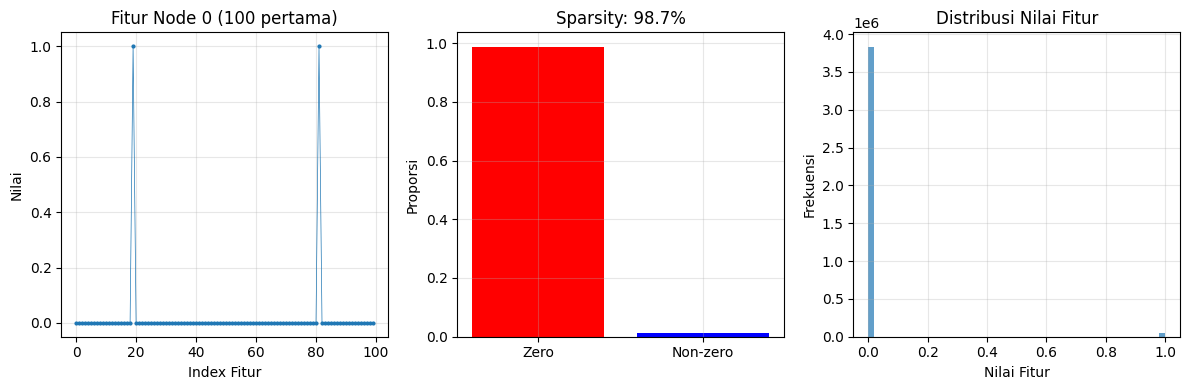

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
# Sample of features for first node
plt.plot(data.x[0, :100].cpu().numpy(), marker='o', markersize=2, linewidth=0.5)
plt.title('Fitur Node 0 (100 pertama)')
plt.xlabel('Index Fitur')
plt.ylabel('Nilai')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Feature sparsity
sparsity = (data.x == 0).sum() / data.x.numel()
plt.bar(['Zero', 'Non-zero'], [sparsity, 1-sparsity], color=['red', 'blue'])
plt.title(f'Sparsity: {sparsity:.1%}')
plt.ylabel('Proporsi')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Feature value distribution
plt.hist(data.x.flatten().cpu().numpy(), bins=50, alpha=0.7)
plt.title('Distribusi Nilai Fitur')
plt.xlabel('Nilai Fitur')
plt.ylabel('Frekuensi')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
# CELL 10: CHECK EDGE STRUCTURE
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Jumlah edge unik: {data.edge_index.shape[1] // 2} (undirected)")
print(f"Contoh edges (5 pertama):")
for i in range(5):
    print(f"  Edge {i}: {data.edge_index[0, i].item()} → {data.edge_index[1, i].item()}")

Edge index shape: torch.Size([2, 10556])
Jumlah edge unik: 5278 (undirected)
Contoh edges (5 pertama):
  Edge 0: 633 → 0
  Edge 1: 1862 → 0
  Edge 2: 2582 → 0
  Edge 3: 2 → 1
  Edge 4: 652 → 1


In [37]:
# CELL 11: CHECK DEGREE DISTRIBUTION
from collections import Counter

# Calculate degree for each node
degrees = {}
for i in range(data.num_nodes):
    degrees[i] = 0

for src, dst in data.edge_index.t().cpu().numpy():
    degrees[src] += 1
    degrees[dst] += 1

degree_values = list(degrees.values())
degree_counter = Counter(degree_values)

print(f"Degree minimum: {min(degree_values)}")
print(f"Degree maksimum: {max(degree_values)}")
print(f"Degree rata-rata: {sum(degree_values)/len(degree_values):.2f}")
print(f"\nTop 5 degree terbanyak:")
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
for node, deg in sorted_degrees[:5]:
    print(f"  Node {node}: degree = {deg}")

Degree minimum: 2
Degree maksimum: 336
Degree rata-rata: 7.80

Top 5 degree terbanyak:
  Node 1358: degree = 336
  Node 306: degree = 156
  Node 1701: degree = 148
  Node 1986: degree = 130
  Node 1810: degree = 88


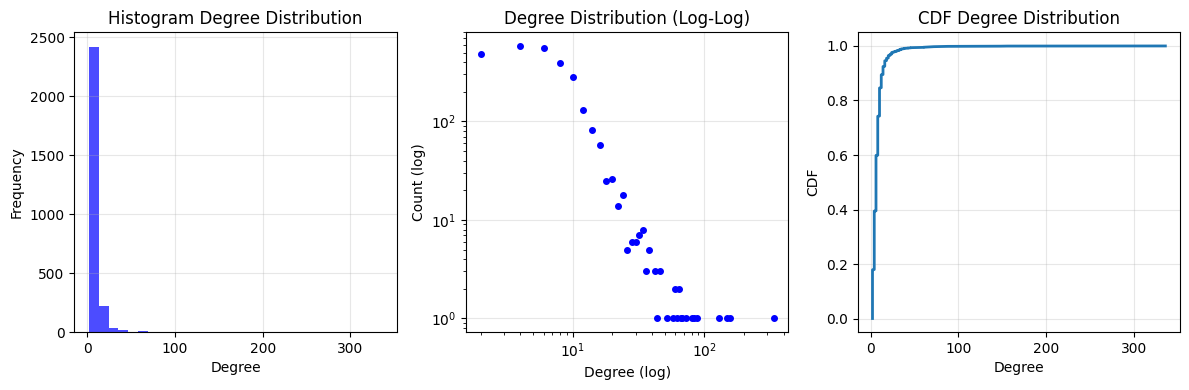

In [38]:
# CELL 12: VISUALIZE DEGREE DISTRIBUTION
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(degree_values, bins=30, alpha=0.7, color='blue')
plt.title('Histogram Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
# Log-log plot untuk power law check
unique_degrees, counts = zip(*sorted(degree_counter.items()))
plt.loglog(unique_degrees, counts, 'bo', markersize=4)
plt.title('Degree Distribution (Log-Log)')
plt.xlabel('Degree (log)')
plt.ylabel('Count (log)')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# CDF
sorted_deg = np.sort(degree_values)
cdf = np.arange(1, len(sorted_deg)+1) / len(sorted_deg)
plt.plot(sorted_deg, cdf, linewidth=2)
plt.title('CDF Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('CDF')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
summary_data = {
    'Metric': ['Jumlah Node', 'Jumlah Edge', 'Dimensi Fitur', 'Jumlah Kelas',
               'Train Nodes', 'Validation Nodes', 'Test Nodes',
               'Edge Density', 'Average Degree'],
    'Value': [data.num_nodes, data.num_edges, data.num_features, dataset.num_classes,
              data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item(),
              f"{edge_density:.4f}", f"{avg_degree:.2f}"],
    'Interpretation': ['Total paper dalam dataset', 'Total citation relationships',
                      'Dimensionality of bag-of-words', 'Number of research topics',
                      'Nodes for training', 'Nodes for validation', 'Nodes for testing',
                      'Very sparse graph', 'Each paper cites ~8 other papers']
}

df_summary = pd.DataFrame(summary_data)
print("📋 SUMMARY TABEL DATASET CORA")
print("="*60)
print(df_summary.to_string(index=False))

📋 SUMMARY TABEL DATASET CORA
          Metric  Value                   Interpretation
     Jumlah Node   2708        Total paper dalam dataset
     Jumlah Edge  10556     Total citation relationships
   Dimensi Fitur   1433   Dimensionality of bag-of-words
    Jumlah Kelas      7        Number of research topics
     Train Nodes    140               Nodes for training
Validation Nodes    500             Nodes for validation
      Test Nodes   1000                Nodes for testing
    Edge Density 0.0014                Very sparse graph
  Average Degree   7.80 Each paper cites ~8 other papers
